# Getting Started with Julia in Colab/Jupyter
You can either run this notebook in Google Colab, or using Jupyter on your own machine.

## Running on Google Colab

1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia (the Jupyter kernel for Julia) and other packages. You can update `JULIA_VERSION` and the other parameters, if you know what you're doing. Installation takes 2-3 minutes.
3. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the _Checking the Installation_ section.

* _Note_: If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2 and 3.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.5.3" # any version ≥ 0.7.0
JULIA_PACKAGES="Knet AutoGrad IJulia BenchmarkTools PyCall PyPlot"
JULIA_PACKAGES_IF_GPU="CUDA"
JULIA_NUM_THREADS=4
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"'
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia
  julia -e 'using Knet;'

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.5.3 on the current Colab Runtime...
2021-01-27 15:31:26 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.5/julia-1.5.3-linux-x86_64.tar.gz [105260711/105260711] -> "/tmp/julia.tar.gz" [1]
Installing Julia package Knet...
 Installing known registries into `~/.julia`
######################################################################## 100.0%
      Added registry `General` to `~/.julia/registries/General`
  Resolving package versions...
  Installed Requires ───────────────────── v1.1.2
  Installed BFloat16s ──────────────────── v0.1.0
  Installed Compat ─────────────────────── v3.25.0
  Installed CodecZlib ──────────────────── v0.7.0
  Installed FileIO ─────────────────────── v1.4.5
  Installed GPUArrays ──────────────────── v6.2.0
  Installed DataStructures ─────────────── v0.18.9
  Installed Reexport ───────────────────── v1.0.0
  Installed OpenSpecFun_jll ────────────── v0.5.3+4
  Installed ExprTools ──────────────────── v0.1.3
  Installed Transcodin

## Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system (if you ever ask for help or file an issue about Julia, you should always provide this information).

In [1]:
versioninfo()

Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, broadwell)
Environment:
  JULIA_NUM_THREADS = 4


# Your Own Work
Write your code under this section.


# COMP541 - LAB #5

<img src="http://drive.google.com/uc?export=view&id=1RJUAUMmViCsYSgyFj7oyqBu4c6AZMeFR">

T-Maze problem was designed to test Reinforcement Learning-LSTM's capability to bridge long time lags, without confounding the results by making the control task difficult in other ways [(Bakker, 2002)](http://papers.nips.cc/paper/1953-reinforcement-learning-with-long-short-term-memory.pdf]). However, we can also use this test-bed for supervised algorithms by exploiting the gold actions.

In the T-Maze problem, the agent has four possible actions: move North, East, South, or West. The agent must learn to move from the starting position at the beginning of the corridor to the T-junction. There it must move either North or South to a changing goal position, which it cannot see. However, the location of the goal depends on a "road sign" the agent has seen at the starting position. At the starting position, the observation is either 011 (North) or 110 (South), in the corridor the observation is 101, and at the T-junction the observation is 010.

In this assignment, you will complete lstm based architecture, train and test the model on different settings to inspect the learning curve and generalization power of the model. You will also explore the behavior of the model by visualizing hidden and cell vectors, and weights.

In [ ]:
using Pkg;

# Install missing packages
for p in ["Knet", "Luxor", "Plots"]
    if !haskey(Pkg.installed(),p)
        Pkg.add(p);
    end
end

using Knet, Luxor, Plots, Random, Printf, Test, Statistics

## General Information
Our goal is 0 for North and 1 for South
Agent can take an action with step function. Directions are 1 for North, 2 for East, 3 for South, and 4 for West. If the action is not permitted, nothing happens in that round. These actions are:
* Taking action North, South or West at the starting point
* Taking action South or North in the corridor
* Taking action East at the T-junction

At each step, our input is as follows:
* At the starting point
  + If end goal is South -> \[1.0, 1.0, 0.0\]
  + If end goal is North -> \[0.0, 1.0, 1.0\]
* In the corridor -> \[1.0, 0.0, 1.0\]
* At the T-junction -> \[0.0, 1.0, 0.0\]

In [3]:
mutable struct TMaze
    length::Int # length except T-junction
    goal::Int # 0 = North, 1 = South
    agent_position::Tuple{Int,Int} # Agent's current position (x, y)
end

function get_state(maze::TMaze)
    """
    Returns the current state for the maze.
    """

    state = zeros(Float32, 3,)

    if maze.agent_position[1] == maze.length # At the T-junction
        state[2] = 1.0
    elseif maze.agent_position[1] == 0 # At the start position
        if maze.goal == 0
            state[2] = 1.0
            state[3] = 1.0
        else
            state[1] = 1.0
            state[2] = 1.0
        end
    else # In the corridor
        state[1] = 1.0
        state[3] = 1.0
    end
    return state
end

function step(maze::TMaze, action::Int)
    """
    Gets action and plays one step. If the resulted state is the final state
    then it checks whether it is the goal state or not. If it is a goal state
    and the correct one it returns 1, if it is wrong it returns -1.
    If the resulted state is not the final state, then it returns 0.
    1 : North
    2 : East
    3 : South
    4 : West
    """
    p = maze.agent_position
    res = 0

    if p[1] == maze.length && p[2] == 0
        if action == 1
            maze.agent_position = (p[1], min(-1, p[2]-1))
            res = maze.goal == 0 ? 1 : -1
        elseif action == 3
            maze.agent_position = (p[1], min(1, p[2]+1))
            res = maze.goal == 0 ? -1 : 1
        elseif action == 4
            maze.agent_position = (p[1]-1, 0)
        end
    elseif p[1] != maze.length && action == 2
        maze.agent_position = (p[1]+1, 0)
    elseif p[1] != maze.length && action == 4
        maze.agent_position = (min(p[1]-1, 0), 0)
    end
    return res
end

function get_gold_actions(maze::TMaze)
    """
    Returns a vector of integer for gold actions
    """

    gold_actions = ones(Int, maze.length) * 2
    push!(gold_actions, maze.goal == 0 ? 1 : 3)
    return gold_actions
end

function get_supervised_states(maze::TMaze)
    """
    Returns the list of states for the gold actions.
    The list includes the starting position, but does not include the final state.
    """

    p = maze.agent_position # store the agent position

    maze.agent_position = (0, 0)

    states = []
    for action in get_gold_actions(maze)
        push!(states, get_state(maze))
        step(maze, action)
    end

    maze.agent_position = p # reset
    return states
end

function draw(maze::TMaze)
    dim = 500 / (2 * (maze.length +1))
    Drawing(500, round(Int, dim*3))
    origin()
    background("white")
    sethue("black")
    box.([O + (i*dim, 0) for i=0:maze.length], dim, dim, :stroke)
    if maze.goal == 0
        sethue("crimson")
        box.(O + (maze.length*dim, -dim), dim, dim, :fill)
        sethue("black")
        box.(O + (maze.length*dim, dim), dim, dim, :stroke)
        if maze.agent_position[1] == 0
            Luxor.arrow(O + (0, -dim*0.65), Point(0, -dim*1.45))
        end
    else
        sethue("crimson")
        box.(O + (maze.length*dim, dim), dim, dim, :fill)
        sethue("black")
        box.(O + (maze.length*dim, -dim), dim, dim, :stroke)
        if maze.agent_position[1] == 0
            Luxor.arrow(O + (0, dim*0.65), Point(0, dim*1.45))
        end
    end
    sethue("steelblue4")
    circle(O + (maze.agent_position[1]*dim,maze.agent_position[2]*dim), dim*0.45, :fill)
    finish()
    display(preview())
    IJulia.clear_output(true)
end

draw (generic function with 1 method)

In [4]:
maze = TMaze(5,1,(0,0));

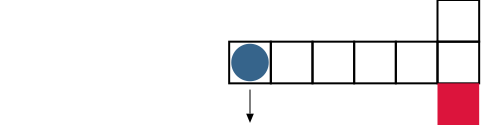

In [5]:
draw(maze);

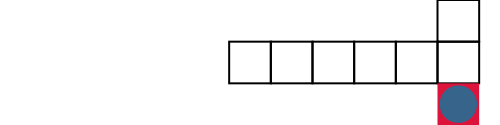

In [6]:
maze2 = TMaze(5,1,(0,0));
draw(maze2)
sleep(1)

# Let's animate
for action in get_gold_actions(maze2)
    res = step(maze2, action)
    draw(maze2)
    # print("Action: $action\n")
    # print("Result: $res")
    sleep(1) # sleep 1 second
end

In [7]:
get_gold_actions(maze)

6-element Array{Int64,1}:
 2
 2
 2
 2
 2
 3

In [8]:
get_supervised_states(maze)

6-element Array{Any,1}:
 Float32[1.0, 1.0, 0.0]
 Float32[1.0, 0.0, 1.0]
 Float32[1.0, 0.0, 1.0]
 Float32[1.0, 0.0, 1.0]
 Float32[1.0, 0.0, 1.0]
 Float32[0.0, 1.0, 0.0]

In [9]:
function get_all_data_up_to(N::Int)
    """
    Generates a list of tuples, where each tuple contains supervised states
    and gold actions for a specific configuration. There are 2N tuples in the
    list.
    """
    data = []
    for i=1:N
        for goal in [0, 1]
            maze = TMaze(i,goal,(0,0));
            states = get_supervised_states(maze)
            actions = get_gold_actions(maze)
            push!(data, (states, actions))
        end
    end
    return data
end

get_all_data_up_to (generic function with 1 method)

In [10]:
data = get_all_data_up_to(3)

6-element Array{Any,1}:
 (Any[Float32[0.0, 1.0, 1.0], Float32[0.0, 1.0, 0.0]], [2, 1])
 (Any[Float32[1.0, 1.0, 0.0], Float32[0.0, 1.0, 0.0]], [2, 3])
 (Any[Float32[0.0, 1.0, 1.0], Float32[1.0, 0.0, 1.0], Float32[0.0, 1.0, 0.0]], [2, 2, 1])
 (Any[Float32[1.0, 1.0, 0.0], Float32[1.0, 0.0, 1.0], Float32[0.0, 1.0, 0.0]], [2, 2, 3])
 (Any[Float32[0.0, 1.0, 1.0], Float32[1.0, 0.0, 1.0], Float32[1.0, 0.0, 1.0], Float32[0.0, 1.0, 0.0]], [2, 2, 2, 1])
 (Any[Float32[1.0, 1.0, 0.0], Float32[1.0, 0.0, 1.0], Float32[1.0, 0.0, 1.0], Float32[0.0, 1.0, 0.0]], [2, 2, 2, 3])

## Problem 1. Implement the LSTM Agent

In [79]:
# model definition
struct Linear
    w
    b
end

# Initializer for a softmax classifier
function Linear(num_inputs::Int, num_outputs::Int; init=gaussian, atype=Knet.atype())
    # Your code here
    Linear(param(num_outputs, num_inputs;init=init,atype), param0(num_outputs;atype))
end

function (l::Linear)(x)
    # Your code here
    l.w * x .+ l.b
end

@info "Testing Linear layer"
Random.seed!(1)
test_linear = Linear(5, 12, init=xavier, atype=Array{Float64,N} where N)
@test typeof(value(test_linear.w)) == Array{Float64,2}
@test typeof(value(test_linear.b[1])) == Float64
@test abs(test_linear.w[4,2] - -0.3451982590137293) < 1e-5
@test abs(mean(test_linear.w, dims=2)[10] - 0.24456877737644933) < 1e-5
@test sum(test_linear.b .== 0.0) == 12
@test abs(mean(test_linear(randn(5,1))[5:10]) - -0.28082191595456435) < 1e-5


struct LSTMNet
    w
    b
end

# Hint you may take a look at the lstm function below to better understand its calling convention
# Remember that, forget gate bias should be ones instead of zeros
function LSTMNet(num_inputs::Int, hidden_size::Int; init=gaussian, atype=Knet.atype())
    # Your code here
    b = convert(atype, zeros(4*hidden_size) )

    b[1:hidden_size] += convert(atype, ones(hidden_size) )

    LSTMNet(param(4 * hidden_size, hidden_size + num_inputs; init=init, atype), param(b; atype))
end

# lstm procedure is given to you
# weight * input .+ bias, concatenated weights for computational efficiency
# You should use this function in your LSTM module call
function lstm(weight, bias, hidden, cell, input)
    gates   = weight * vcat(hidden,input) .+ bias
    hsize   = size(hidden,1)
    forget  = sigm.(gates[1:hsize,:])
    ingate  = sigm.(gates[1+hsize:2hsize,:])
    outgate = sigm.(gates[1+2hsize:3hsize,:])
    change  = tanh.(gates[1+3hsize:end,:])
    cell    = cell .* forget + ingate .* change
    hidden  = outgate .* tanh.(cell)
    return (hidden, cell)
end

function (l::LSTMNet)(x, prev_hidden, prev_cell)
    # Your code here
    hidden, cell = lstm(l.w, l.b, prev_hidden, prev_cell, x)

    return (hidden, cell)
end

@info "Testing LSTMNet layer"
Random.seed!(1)
test_lstmnet = LSTMNet(5, 12, init=xavier, atype=Array{Float64,N} where N)
@test size(test_lstmnet.w) == (48, 17)
@test length(test_lstmnet.b) == 48
@test typeof(value(test_lstmnet.w)) == Array{Float64,2}
@test typeof(value(test_lstmnet.b[1])) == Float64
@test abs(test_lstmnet.w[33, 7] - 0.07483133069296893) < 1e-5
@test abs(mean(test_lstmnet.w, dims=1)[9] - -0.014140538516031594) < 1e-5
@test sum(test_lstmnet.b[1:12]) == 12
@test sum(test_lstmnet.b[13:end] .== 0) == 36
@test abs(mean(test_lstmnet(randn(5,1), zeros(12,1), zeros(12,1))[1][3:7]) - 0.014609052609425932) < 1e-5


mutable struct LSTMAgent
    lstm::LSTMNet # a lstm network
    linear::Linear # a linear layer on top of the lstm network
    state # An array for hidden and cell states
    atype # Array{Float32} or KnetArray{Float32}. Defaults to Knet.atype()
end

# resets the hidden and cell states
function reset!(model::LSTMAgent)
    state = Array{Any}(undef, 2)
    state[1] = convert(model.atype, zeros(size(model.state[1])))
    state[2] = convert(model.atype, zeros(size(model.state[1])))
    model.state = state
end

function LSTMAgent(hidden_size::Int, world_dim::Int=3, num_actions::Int=4; atype=Knet.atype())
    # Your code here
    LSTMAgent(LSTMNet(world_dim, hidden_size, atype=atype), Linear(hidden_size, num_actions, atype=atype), [zeros(hidden_size), zeros(hidden_size)], atype)
end


# You would normally call reset! function before calling your model,
# but to accomodate a test instead of calling reset! once in this function
# I added reset! calls everywhere before we call model.
# Do not call reset! in this function or one of the tests will fail.
# model gets world state(s) and applies the lstm function to each state in the world_states
# and predicts a score vector for actions.
# Don't forget to convert the data to atype!
function (model::LSTMAgent)(world_states)
    scores = []
    # Your code here
    reset!(model)
    
    hidden, cell= model.state

    for i in world_states
        hidden, cell = model.lstm(i, hidden, cell)
        model.state = [hidden, cell]
        push!(scores, model.linear(model.state[1]))
    end
    
    return scores
end

@info "Testing LSTMAgent"
Random.seed!(1)
test_lstmagent = LSTMAgent(5, 2, 3, atype=Array{Float64,N} where N)
@test typeof(test_lstmagent.lstm) <: LSTMNet
@test typeof(test_lstmagent.linear) <: Linear
@test typeof(value(test_lstmagent.lstm.w)) == Array{Float64,2}
@test typeof(value(test_lstmagent.linear.w)) == Array{Float64,2}
@test size(test_lstmagent.lstm.w) == (20, 7)
@test size(test_lstmagent.linear.w) == (3, 5)
@test length(test_lstmagent.state) == 2
@test typeof(test_lstmagent.state[1]) <: Array{Float64}
@test typeof(test_lstmagent.state[2]) <: Array{Float64}
@test sum(test_lstmagent.state[1] .== 0) == 5
@test sum(test_lstmagent.state[2] .== 0) == 5
test_lstmagent_scores = test_lstmagent([Float64[3.0, 4.5], Float64[0.5, 2.0], Float64[1.0, 0.0]])
@test length(test_lstmagent_scores) == 3
@test abs(test_lstmagent_scores[2][1] - -0.00038354785781416414) < 1e-5
# Testing if forward function actually updates the model.state
test_lstmagent_scores = test_lstmagent([Float64[3.0, 4.5], Float64[0.5, 2.0], Float64[1.0, 0.0]])
@test abs(test_lstmagent_scores[2][1] - -0.0005447451298615854) < 1e-5
# Testing if the input is converted to atype inside the forward function
# This throws DimensionMismatch if it is not converted into atype first
@test_throws MethodError test_lstmagent([[Float64[3.0, 4.5], Float64[0.5, 2.0], Float64[1.0, 0.0]]])

┌ Info: Testing Linear layer
└ @ Main In[79]:18
┌ Info: Testing LSTMNet layer
└ @ Main In[79]:67
┌ Info: Testing LSTMAgent
└ @ Main In[79]:125


Test Failed at In[79]:144
  Expression: abs((test_lstmagent_scores[2])[1] - -0.0005447451298615854) < 1.0e-5
   Evaluated: 0.00016119727204742123 < 1.0e-5


LoadError: ignored

## Problem 2. Implement Loss function
This function basically takes the predictions and returns the negative log-likelihood of these predictions as loss.
Hint: You may have a look Knet's at ```nll``` function

In [105]:
# our loss function
function loss(model, world_states, gold_actions)
    """
    Takes a model, input states and gold actions.
    Returns average loss of actions predicted by the model.
    """
    scores = model(world_states)
    # Your code here
    tot = 0.0
    for i in 1:length(scores)
        tot += nll(scores[i], [gold_actions[i]])
    end
    lossvalue = tot/length(gold_actions)
    #end

    return lossvalue
end

@info "Testing loss function"
Random.seed!(1)
test_loss = loss(identity, [zeros(4,1), randn(4,1), randn(4,1), randn(4,1), randn(4,1)], [2,1,3,2,4])
@test abs(test_loss - 1.184270190413555) < 1e-5

┌ Info: Testing loss function
└ @ Main In[105]:19


Test Passed

In [82]:
function train!(model, world_states, gold_actions)
    L = @diff loss(model, world_states, gold_actions)
    for p in params(model)
        g = grad(L, p)
        update!(value(p), g, p.opt)
    end
    return value(L)
end

train! (generic function with 1 method)

## Problem 3. Implement accuracy function
Hint: You will need ```argmax``` function
Don't forget to convert the model output to Array, since it can be a KnetArray if you are using GPU.

In [102]:
# possible helpful procedures: vec
function path_accuracy(model, data)
    """
    This function takes a model and a data array,
    and returns an array of 1's and 0's for the correctness
    of that action set. In order for the action set's result
    to be 1, each move has to be correct (same with the gold
    action in that state).
    """
    accuracies = []
    for (world_states, gold_actions) in data
        ncorrect = 0
        reset!(model)
        scores = model(world_states)
        # ncorrect must be equal to the path length (i.e. length of the gold actions)

        # Your code here
        for i in 1:length(scores)
            prediction = argmax(scores[i])
            nthgold = gold_actions[i]
            
            if prediction[1] == nthgold
                ncorrect = ncorrect + 1
            end
        end

        push!(accuracies, ncorrect == length(gold_actions) ? 1.0 : 0.0)
    end

    return accuracies
end

@info "Testing accuracy function"
mutable struct MockModel; end
(m::MockModel)(states) = states
reset!(m::MockModel) = 0
test_acc = path_accuracy(MockModel(), [([[zeros(2,1)]], [2]), ([[0.8, 0.2]], [1]), ([[0.3, 0.2, 0.5]], [3])])
@test test_acc == [0.0, 1.0, 1.0]

┌ Info: Testing accuracy function
└ @ Main In[102]:33


Test Passed

In [84]:
function train_until_all_success(model, data; maxe=50000)
    """
    Gets model parameters w, initial states s, optimizers opt and data.
    It trains the model untill the accuracy on the data reach to 1.0.
    """
    experiment = []
    for i=1:maxe
        world_states, gold_actions = rand(data) #sample data
        reset!(model)
        train!(model, world_states, gold_actions)

        accuracies = path_accuracy(model, data)
        total = sum(accuracies)/length(accuracies)
        push!(experiment, total)
        print("\r Number of Instances: $i Acc: $(@sprintf("%.3f", total))")
        if total == 1.0
            break
        end
    end
    return experiment
end

train_until_all_success (generic function with 1 method)

In [85]:
data = get_all_data_up_to(10);

In [86]:
# Model with 4 hidden_size
Knet.seed!(1)
HIDDEN = 4

model_4 = LSTMAgent(HIDDEN, atype=Array{Float32})
for p in params(model_4)
    p.opt = Adam()
end

Random.seed!(1)
hidden_4 = train_until_all_success(model_4, data; maxe=100000);

 Number of Instances: 13714 Acc: 0.500

Excessive output truncated after 524364 bytes.

 Number of Instances: 13728 Acc: 0.500

In [87]:
# Model with 8 hidden_size
Knet.seed!(1)
HIDDEN = 8

model_8 = LSTMAgent(HIDDEN, atype=Array{Float32})
for p in params(model_8)
    p.opt = Adam()
end

Random.seed!(1)
hidden_8 = train_until_all_success(model_8, data; maxe=100000);

 Number of Instances: 13710 Acc: 0.500

Excessive output truncated after 524364 bytes.

 Number of Instances: 13728 Acc: 0.500

In [88]:
# Model with 16 hidden_size
Knet.seed!(3)
HIDDEN = 16

model_16 = LSTMAgent(HIDDEN, atype=Array{Float32})
for p in params(model_16)
    p.opt = Adam()
end

Random.seed!(3)
hidden_16 = train_until_all_success(model_16, data; maxe=100000);

 Number of Instances: 9879 Acc: 1.000

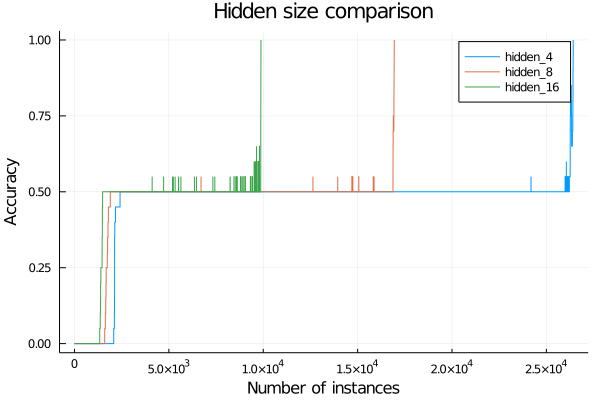

In [89]:
plot([1:length(hidden_4), 1:length(hidden_8), 1:length(hidden_16)],
    [hidden_4, hidden_8, hidden_16],
    label=["hidden_4" "hidden_8" "hidden_16"],
    xlabel="Number of instances", ylabel="Accuracy", title="Hidden size comparison")

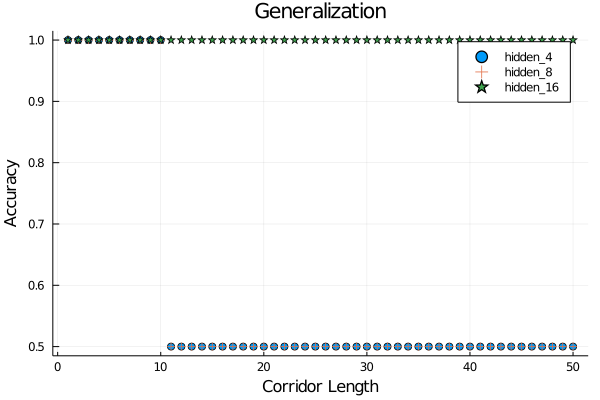

In [90]:
limit = 50
test_data = get_all_data_up_to(limit);

accuracies = path_accuracy(model_4, test_data)
N_4 = map(x->sum(accuracies[(x-1)*2+1:x*2])/2, 1:limit);

accuracies = path_accuracy(model_8, test_data)
N_8 = map(x->sum(accuracies[(x-1)*2+1:x*2])/2, 1:limit);

accuracies = path_accuracy(model_16, test_data)
N_16 = map(x->sum(accuracies[(x-1)*2+1:x*2])/2, 1:limit);

plot([N_4 N_8 N_16], linetype=:scatter, m=[:circle :cross :star5],
    label=["hidden_4" "hidden_8" "hidden_16"],
    xlabel="Corridor Length", ylabel="Accuracy", title="Generalization")

hidden_4 and hidden_8 models can only handle up to corridor length equals to 10. However, hidden_16 is able to solve the task. Let's inspect the behaviour of this model.

## Problem 4. Implement Play function
Hint: part of the code is the same as in path_accuracy function.
Don't forget to convert the model prediction to Array, since it can be a KnetArray if you are using GPU.

In [107]:
function play(maze, model; max_actions=20)
    """
    This function gets a maze, a trained model and
    initial states s. It takes action using the model
    until either the agent reaches the final state or
    exceeds the maximum action limit. The function
    returns the actions taken, hidden and cell states
    of the lstm.
    """
    res = 0
    action_count = 0
    hiddens = []
    cells = []
    actions = []
    draw(maze)
    reset!(model)
    while !(res != 0 || action_count >= max_actions)
        sleep(1) # sleep 1 second
        x = get_state(maze) # get state

        # Your code here
        h, c = model.state
        h, c = model.lstm(x, h, c)
        push!(actions, argmax(model.linear(h))[1])
        
        action = argmax(model.linear(h))[1]

        res = step(maze, action) # prediction from the model
        draw(maze)
        action_count += 1
    end

    return actions, hiddens, cells
end

@info "Testing play function"
test_maze = TMaze(8, 1, (0,0))
test_actions, test_hiddens, test_cells = play(test_maze, model_16)
@test length(test_hiddens) == 9
@test length(test_cells) == 9
@test typeof(test_hiddens[1]) <: Array
@test typeof(test_cells[1]) <: Array
@test abs(mean(test_hiddens[5]) - -0.13866028f0) < 1e-5
@test abs(mean(test_cells[3]) - -0.15613154f0) < 1e-5

Test Failed at In[107]:39
  Expression: length(test_hiddens) == 9
   Evaluated: 0 == 9


LoadError: ignored

In [ ]:
maze = TMaze(5, 0, (0, 0))
actions_0, hiddens_0, cells_0 = play(maze, model_16);

### Hidden and cell state visualizations

In [ ]:
xs = [string("state", i) for i = 1:maze.length+1]
ys = [string("unit", i) for i = 1:16]
heatmap(xs, ys, hcat(hiddens_0...), title="Hidden states for a maze(length=5) and the goal is north")

In [ ]:
xs = [string("state", i) for i = 1:maze.length+1]
ys = [string("unit", i) for i = 1:16]
heatmap(xs, ys, hcat(cells_0...), title="Cell states for a maze(length=5) and the goal is north")

In [ ]:
maze = TMaze(5, 1, (0, 0))
actions_1, hiddens_1, cells_1 = play(maze, model_16);

In [ ]:
xs = [string("state", i) for i = 1:maze.length+1]
ys = [string("unit", i) for i = 1:16]
heatmap(xs, ys, hcat(hiddens_1...), title="Hidden states for a maze(length=5) and the goal is south")

In [ ]:
xs = [string("state", i) for i = 1:maze.length+1]
ys = [string("unit", i) for i = 1:16]
heatmap(xs, ys, hcat(cells_1...), title="Cell states for a maze(length=5) and the goal is south")

Until the t-junction, the model preserves the hidden state and at the t-junction it switches hidden state for the final prediction.

### Some weight visualization

In [ ]:
xs = [string("x", i) for i = 1:3]
ys = [string("w", i) for i = 1:16]
heatmap(xs, ys, value(model_16.lstm.w)[1:16,17:19], title="Forget gate weight used in W_forget * x_t")

In [ ]:
xs = [string("x", i) for i = 1:3]
ys = [string("w", i) for i = 1:16]
heatmap(xs, ys, value(model_16.lstm.w)[17:32,17:19], title="Input gate weight used in W_input * x_t")

In [ ]:
xs = [string("h", i) for i = 1:16]
ys = [string("w", i) for i = 1:16]
heatmap(xs, ys, value(model_16.lstm.w)[17:32,1:16], title="Input gate weight used in W_input * prev_hidden")

Do not bother making any comment about this last heatmap.

Now discuss the findings from the figures.

Your Comment:

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*